In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import nilearn
from nilearn.connectome import ConnectivityMeasure
# import matplotlib as mpl
# mpl.use('Agg')

/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sites = ['CALTECH', 'CMUA', 'KKI', 'LEUVEN1', 'LEUVEN2', 'MAXMUNA', 'MAXMUNB', 'MAXMUNC', 'MAXMUNC', 'NYU', 'OHSU', 'OLIN', 'PITT', 'SBL', 'SDSU',
         'STANFORD', 'TRINITY', 'UCLA1', 'UCLA2', 'UM1', 'UM2', 'USM', 'YALE']

In [4]:
abide = nilearn.datasets.fetch_abide_pcp(derivatives=['rois_aal'], SITE_ID=sites, pipeline='cpac')

In [78]:
ages = abide.phenotypic['AGE_AT_SCAN']

In [79]:
age_groups = [np.sum(np.logical_and(ages >= 5, ages <= 10)), np.sum(np.logical_and(ages >= 10, ages <= 15)), np.sum(np.logical_and(ages >= 15, ages <= 20)),
              np.sum(np.logical_and(ages >= 20, ages <= 30)), np.sum(np.logical_and(ages >= 30, ages <= 65))]

In [80]:
age_groups

[88, 203, 124, 107, 43]

<StemContainer object of 3 artists>

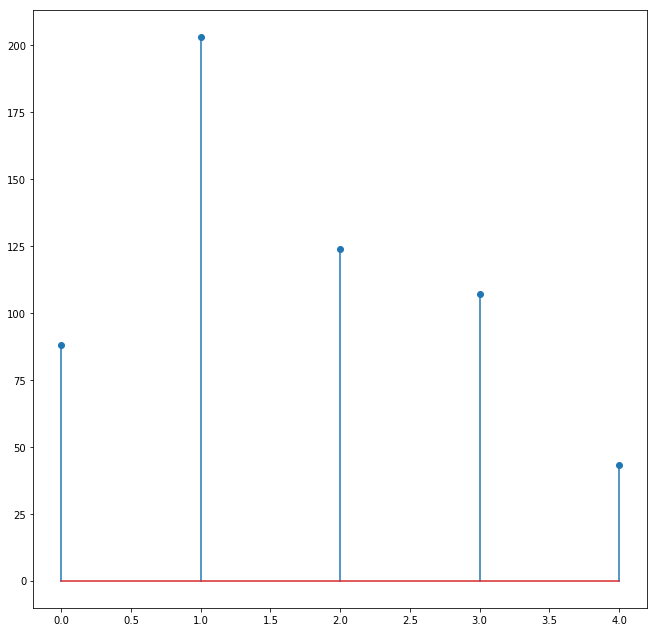

In [8]:
plt.figure(figsize=(11,11))
plt.stem(age_groups)

In [9]:
conn_est = ConnectivityMeasure(kind='partial correlation')
conn_matrices = conn_est.fit_transform(abide.rois_aal)
conn_matrices.shape

(553, 116, 116)

In [12]:
import bct

In [13]:
np.percentile(conn_matrices[0,...], 80)

0.055674631053385513

In [25]:
num_subs = conn_matrices.shape[0]
num_roi = conn_matrices.shape[1]

In [16]:
ct_bi = np.zeros((conn_matrices.shape))
for i in range(ct_bi.shape[0]):
    ct_bi[i,...][conn_matrices[i,...] >= np.percentile(conn_matrices[i,...], 80)] = 1

In [26]:
clust_coef = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    clust_coef[i,:] = bct.clustering_coef_bu(ct_bi[i,...])

In [27]:
trans = np.zeros((num_subs,1))

for i in range(num_subs):
    trans[i] = bct.transitivity_bu(ct_bi[i,...])

In [28]:
char_path = np.zeros((num_subs,num_roi + 4))

for i in range(num_subs):
    char_path_res = bct.charpath(bct.distance_bin(ct_bi[i,...]))
    char_path[i,:num_roi] = char_path_res[2]
    char_path[i,num_roi] = char_path_res[0]
    char_path[i,num_roi + 1] = char_path_res[1]
    char_path[i,num_roi + 2] = char_path_res[3]
    char_path[i,num_roi + 3] = char_path_res[4]

/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [29]:
eff = np.zeros((num_subs,num_roi + 1))

for i in range(num_subs):
    eff[i,:num_roi] = bct.efficiency_bin(ct_bi[i,...], local=True)
    eff[i,num_roi] = bct.efficiency_bin(ct_bi[i,...])

In [30]:
btw_cen = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    btw_cen[i,:] = bct.betweenness_bin(ct_bi[i,...])

In [38]:
mod_z_score = np.zeros((num_subs,num_roi))
part_coef = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    comms, _ = bct.community_louvain(ct_bi[i,...])
    
    mod_z_score[i,:] = bct.module_degree_zscore(ct_bi[i,...], comms)
    part_coef[i,:] = bct.participation_coef(ct_bi[i,...], comms)

/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/bct/algorithms/centrality.py:642: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


In [39]:
X = np.hstack((clust_coef, trans, char_path, eff, btw_cen, mod_z_score, part_coef))

In [40]:
X.shape

(553, 702)

In [43]:
import sklearn
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [45]:
y = abide.phenotypic['DX_GROUP']

553

In [48]:
shuffle = np.hstack((X, y.reshape(-1,1)))
np.random.shuffle(shuffle)
X_shuffle = shuffle[:,:-1]
y_shuffle = shuffle[:,-1]

In [49]:
print(X_shuffle.shape, y_shuffle.shape)

(553, 702) (553,)


In [53]:
nanm = np.isnan(X_shuffle)
len(np.where(np.sum(nanm, axis=0) > 0)[0])

118

In [54]:
X_final = np.delete(X_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)

In [58]:
nanm = np.isinf(X_final)
len(np.where(np.sum(nanm, axis=0) > 0)[0])

1

In [59]:
X_finalfinal = np.delete(X_final, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)

In [60]:
X_finalfinal.shape

(553, 583)

In [61]:
svm = sklearn.svm.SVC(kernel='linear')

sfs1 = SFS(svm, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X_finalfinal, y_shuffle)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:  8.3min finished

[2019-11-14 15:38:33] Features: 1/10 -- score: 0.5949367088607594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:   20.3s finished

[2019-11-14 15:38:53] Features: 2/10 -- score: 0.6057866184448463[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   18.4s finished

[2019-11-14 15:39:12] Features: 3/10 -- score: 0.6166365280289331[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [62]:
sfs1.k_feature_idx_

(9, 18, 35, 131, 181, 351, 459, 525, 558, 569)

In [73]:
X_top10 = X_finalfinal[:,sfs1.k_feature_idx_]
X_top10.shape

(553, 10)

In [75]:
all_iter_results = []
for i in range(100):
    all_iter_results.append([])
    kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
    for train_index, test_index in kf.split(X_top10):
        X_train, X_test = X_top10[train_index], X_top10[test_index]
        y_train, y_test = y_shuffle[train_index], y_shuffle[test_index]

        clf = sklearn.svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
        specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
        all_iter_results[i].append([sensitivity, specificity])

In [76]:
clf_results = np.array(all_iter_results)

clf_iter_avg = []
for i in range(clf_results.shape[0]):
    clf_iter = clf_results[i,:,:]
    clf_iter_avg.append(np.mean(clf_iter, axis=0))
    
clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])

In [77]:
clf_df0.mean()

Sensitivity    0.833902
Specificity    0.220079
dtype: float64

In [81]:
X_a1 = X[np.logical_and(ages >= 5, ages < 10),:]
X_a2 = X[np.logical_and(ages >= 10, ages < 15),:]
X_a3 = X[np.logical_and(ages >= 15, ages < 20),:]
X_a4 = X[np.logical_and(ages >= 20, ages < 30),:]
X_a5 = X[np.logical_and(ages >= 30, ages < 65),:]

y_a1 = y[np.logical_and(ages >= 5, ages < 10)]
y_a2 = y[np.logical_and(ages >= 10, ages < 15)]
y_a3 = y[np.logical_and(ages >= 15, ages < 20)]
y_a4 = y[np.logical_and(ages >= 20, ages < 30)]
y_a5 = y[np.logical_and(ages >= 30, ages < 65)]

In [82]:
data = [(X_a1, y_a1), (X_a2, y_a2), (X_a3, y_a3), (X_a4, y_a4), (X_a5, y_a5)]

In [ ]:
shuffle = np.hstack((X, y.reshape(-1,1)))
np.random.shuffle(shuffle)
X_shuffle = shuffle[:,:-1]
y_shuffle = shuffle[:,-1]

nanm = np.isnan(X_shuffle)
X_final = np.delete(X_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
infm = np.isinf(X_final)
X_finalfinal = np.delete(X_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)

In [85]:
for group in data:
    xc = group[0]
    yc = group[1]
    shuffle = np.hstack((xc, yc.reshape(-1,1)))
    np.random.shuffle(shuffle)
    xc_shuffle = shuffle[:,:-1]
    yc_shuffle = shuffle[:,-1]
    
    nanm = np.isnan(xc_shuffle)
    xc_final = np.delete(xc_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
    infm = np.isinf(xc_final)
    xc_finalfinal = np.delete(xc_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)
    
    sfs1 = sfs1.fit(xc_finalfinal, yc_shuffle)
    xc_top10 = xc_finalfinal[:,sfs1.k_feature_idx_]
    
    all_iter_results = []
    for i in range(100):
        all_iter_results.append([])
        kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
        for train_index, test_index in kf.split(xc_top10):
            X_train, X_test = xc_top10[train_index], xc_top10[test_index]
            y_train, y_test = yc_shuffle[train_index], yc_shuffle[test_index]

            clf = sklearn.svm.SVC(kernel='linear')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
            specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
            all_iter_results[i].append([sensitivity, specificity])
            
    clf_results = np.array(all_iter_results)

    clf_iter_avg = []
    for i in range(clf_results.shape[0]):
        clf_iter = clf_results[i,:,:]
        clf_iter_avg.append(np.mean(clf_iter, axis=0))

    clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])
    
    print(clf_df0.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:   38.7s finished

[2019-11-14 17:04:02] Features: 1/10 -- score: 0.686046511627907[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:    9.2s finished

[2019-11-14 17:04:12] Features: 2/10 -- score: 0.7441860465116279[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   13.1s finished

[2019-11-14 17:04:25] Features: 3/10 -- score: 0.7558139534883721[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Sensitivity    0.748283
Specificity    0.546492
dtype: float64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:  2.9min finished

[2019-11-14 17:11:55] Features: 1/10 -- score: 0.625[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:   16.0s finished

[2019-11-14 17:12:11] Features: 2/10 -- score: 0.66[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   45.6s finished

[2019-11-14 17:12:57] Features: 3/10 -- score: 0.685[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaini

Sensitivity    0.765660
Specificity    0.416284
dtype: float64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:    3.4s finished

[2019-11-14 17:40:37] Features: 1/10 -- score: 0.6218487394957983[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:   10.7s finished

[2019-11-14 17:40:48] Features: 2/10 -- score: 0.6722689075630253[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   11.6s finished

[2019-11-14 17:40:59] Features: 3/10 -- score: 0.7058823529411765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Sensitivity    0.686396
Specificity    0.563802
dtype: float64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:   58.8s finished

[2019-11-14 17:43:47] Features: 1/10 -- score: 0.6476190476190476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:    8.5s finished

[2019-11-14 17:43:55] Features: 2/10 -- score: 0.6857142857142857[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   14.1s finished

[2019-11-14 17:44:10] Features: 3/10 -- score: 0.7047619047619048[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Sensitivity    0.813705
Specificity    0.610298
dtype: float64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:    9.1s finished

[2019-11-14 17:59:32] Features: 1/10 -- score: 0.6976744186046512[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:    5.4s finished

[2019-11-14 17:59:37] Features: 2/10 -- score: 0.7441860465116279[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   14.6s finished

[2019-11-14 17:59:52] Features: 3/10 -- score: 0.813953488372093[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Sensitivity    0.633833
Specificity    0.796300
dtype: float64


/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [90]:
np.array(clf_df0.mean()).shape

(2,)

In [87]:
kinds = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision']

In [ ]:
results_all = {}
for kind in kinds:
    svm_results = np.zeros((len(kinds), 2))
    
    conn_est = ConnectivityMeasure(kind=kind)
    conn_matrices = conn_est.fit_transform(abide.rois_aal)
    
    ct_bi = np.zeros((conn_matrices.shape))
    for i in range(ct_bi.shape[0]):
        ct_bi[i,...][conn_matrices[i,...] >= np.percentile(conn_matrices[i,...], 80)] = 1
        
    clust_coef = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        clust_coef[i,:] = bct.clustering_coef_bu(ct_bi[i,...])
        
    trans = np.zeros((num_subs,1))
    for i in range(num_subs):
        trans[i] = bct.transitivity_bu(ct_bi[i,...])
        
    char_path = np.zeros((num_subs,num_roi + 4))
    for i in range(num_subs):
        char_path_res = bct.charpath(bct.distance_bin(ct_bi[i,...]))
        char_path[i,:num_roi] = char_path_res[2]
        char_path[i,num_roi] = char_path_res[0]
        char_path[i,num_roi + 1] = char_path_res[1]
        char_path[i,num_roi + 2] = char_path_res[3]
        char_path[i,num_roi + 3] = char_path_res[4]
    
    eff = np.zeros((num_subs,num_roi + 1))
    for i in range(num_subs):
        eff[i,:num_roi] = bct.efficiency_bin(ct_bi[i,...], local=True)
        eff[i,num_roi] = bct.efficiency_bin(ct_bi[i,...])
        
    btw_cen = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        btw_cen[i,:] = bct.betweenness_bin(ct_bi[i,...])
        
    mod_z_score = np.zeros((num_subs,num_roi))
    part_coef = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        comms, _ = bct.community_louvain(ct_bi[i,...])

        mod_z_score[i,:] = bct.module_degree_zscore(ct_bi[i,...], comms)
        part_coef[i,:] = bct.participation_coef(ct_bi[i,...], comms)
        
    X = np.hstack((clust_coef, trans, char_path, eff, btw_cen, mod_z_score, part_coef))
    X_a1 = X[np.logical_and(ages >= 5, ages < 10),:]
    X_a2 = X[np.logical_and(ages >= 10, ages < 15),:]
    X_a3 = X[np.logical_and(ages >= 15, ages < 20),:]
    X_a4 = X[np.logical_and(ages >= 20, ages < 30),:]
    X_a5 = X[np.logical_and(ages >= 30, ages < 65),:]

    y_a1 = y[np.logical_and(ages >= 5, ages < 10)]
    y_a2 = y[np.logical_and(ages >= 10, ages < 15)]
    y_a3 = y[np.logical_and(ages >= 15, ages < 20)]
    y_a4 = y[np.logical_and(ages >= 20, ages < 30)]
    y_a5 = y[np.logical_and(ages >= 30, ages < 65)]
    
    data = [(X_a1, y_a1), (X_a2, y_a2), (X_a3, y_a3), (X_a4, y_a4), (X_a5, y_a5)]
    for g, group in enumerate(data):
        xc = group[0]
        yc = group[1]
        shuffle = np.hstack((xc, yc.reshape(-1,1)))
        np.random.shuffle(shuffle)
        xc_shuffle = shuffle[:,:-1]
        yc_shuffle = shuffle[:,-1]

        nanm = np.isnan(xc_shuffle)
        xc_final = np.delete(xc_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
        infm = np.isinf(xc_final)
        xc_finalfinal = np.delete(xc_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)

        sfs1 = sfs1.fit(xc_finalfinal, yc_shuffle)
        xc_top10 = xc_finalfinal[:,sfs1.k_feature_idx_]

        all_iter_results = []
        for i in range(100):
            all_iter_results.append([])
            kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
            for train_index, test_index in kf.split(xc_top10):
                X_train, X_test = xc_top10[train_index], xc_top10[test_index]
                y_train, y_test = yc_shuffle[train_index], yc_shuffle[test_index]

                clf = sklearn.svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
                specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
                all_iter_results[i].append([sensitivity, specificity])

        clf_results = np.array(all_iter_results)

        clf_iter_avg = []
        for i in range(clf_results.shape[0]):
            clf_iter = clf_results[i,:,:]
            clf_iter_avg.append(np.mean(clf_iter, axis=0))

        clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])
        svm_results[g,:] = np.array(clf_df0.mean()).reshape(-1,1)
        
    results_all[kind] = svm_results

/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  # This branch is needed for reductions like any which don't
/Users/anthony.mekhanik/anaconda3/lib/python3.6/site-packages/bct/algorithms/centrality.py:642: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
